In [1]:
%%time
import inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(0,parentdir) 

import csv
from tqdm import tqdm
import json
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(suppress=True)


from Artha.nlp_extraction import run_pipeline, load_backup, format_tweets
from Artha.neodb import Neo
from Artha.mentions import *
from Artha.binance_data import get_klines_df, client

CPU times: user 2.61 s, sys: 528 ms, total: 3.14 s
Wall time: 3.22 s


In [2]:
# coins database

neo = Neo("neo4j://localhost:7687", "neo4j", "part2")

print(len(neo.get_nodes()), len(neo.get_relations()))
# without mentions 711 6958
# neo.clear_nodes()

142 301


In [5]:
%%time

follow_weight = .5

# sample output element: ['checkra_', '995500158417711104', 'Loma', 'LomahCrypto']
def load_following(username, location="../data/follows/u"):
    with open(location+username+".csv", "r") as csvfile:
        reader = csv.reader(csvfile, delimiter=',', )
        next(reader, None)
        follows = list(reader)
        return [[username]+follow for follow in follows]


# add follows between only people I follow, can change by getting rid of second 2 last line for anyone a person follows

# all_people = [i[1:-4] for i in os.listdir("../data/follows/")]
# checkra_people = [c[3] for c in load_following("checkra_") ]


selected_people = ["BTC_JackSparrow", "Nostranomist", "CryptoKaleo", "nebraskangooner", "Rager", "SavageBTC", "TraderMayne", "IamCryptoWolf", "CryptoNewton"]
selected_nodes = [c for c in load_following("checkra_") if c[3] in selected_people]

selected_follows = []
for user in selected_people:
    follows = [i for i in load_following(user) if i[3] in selected_people]
    selected_follows.extend([i + [follow_weight * (1/len(follows))] for i in follows])


CPU times: user 21.2 ms, sys: 3.44 ms, total: 24.7 ms
Wall time: 28.9 ms


In [6]:
%%time
# print(len(follows))
neo.clear_nodes()

neo.load_follow_nodes(selected_nodes)
neo.load_follow_nodes(selected_follows)
neo.load_follow_relations(selected_follows)

print(len(neo.get_nodes()), len(neo.get_relations()))


8 22
CPU times: user 8.66 ms, sys: 2.9 ms, total: 11.6 ms
Wall time: 1.03 s


In [7]:
%%time
# load all tweets

# tweets folder is recent tweets, tweets1 is full tweet history
location = "../data/tweets1/u"

# all tweets list of all tweets of all selected people
all_tweets = []
for ind, username in tqdm(enumerate(selected_people)):
    with open(location+username+".json", "r") as r:
        all_tweets.extend([tweet for tweet in format_tweets(json.load(r), username)])

print("\n", len(all_tweets))



#process all tweets at once
docs = run_pipeline(all_tweets)

# docs = load_backup()

# filter docs into proper speaker

doc_dict = {}
for doc in tqdm(docs):
    if doc._.username not in doc_dict.keys():
        doc_dict[doc._.username] = [doc]
    else:
        doc_dict[doc._.username].append(doc)

9it [00:01,  5.67it/s]
0it [00:00, ?it/s]
 77027
77027it [01:06, 1157.60it/s]
100%|██████████| 19935/19935 [00:00<00:00, 145919.96it/s]CPU times: user 1min 4s, sys: 3.56 s, total: 1min 7s
Wall time: 1min 8s



In [8]:
%%time
# code for multiple graphs over time
day_scores = {}
start_date, window_count = "03/01/2021 00:00:00", 63

dates = [from_datetime(to_datetime(start_date)+timedelta(days=i)) for i in range(window_count)]

for date in tqdm(dates):
    all_mentions = [edge for person in selected_people 
                    for edge in get_mention_edges(
                                      doc_dict[person], person,
                                      follow_weight = follow_weight,
                                      win_start_date = date)]
    neo.clear_nodes("Coin")
    neo.load_mentions(all_mentions)
    day_scores[date] = neo.pagerank_scores()

all_ticks = list(set([tick[0] for day in dates for tick in day_scores[day]]))

tick_dict = {tick: np.zeros(window_count) for tick in all_ticks}

for ind, day in enumerate(day_scores.keys()):
    for score in day_scores[day]:
        tick_dict[score[0]][ind] = score[1]

pdrank = pd.DataFrame(tick_dict, index = pd.to_datetime(dates))
pdrank.to_csv("pgrankdata.csv", index=True)


100%|██████████| 63/63 [00:53<00:00,  1.17it/s]CPU times: user 2min 2s, sys: 25.4 s, total: 2min 27s
Wall time: 53.7 s



CPU times: user 110 ms, sys: 48.9 ms, total: 159 ms
Wall time: 1.4 s


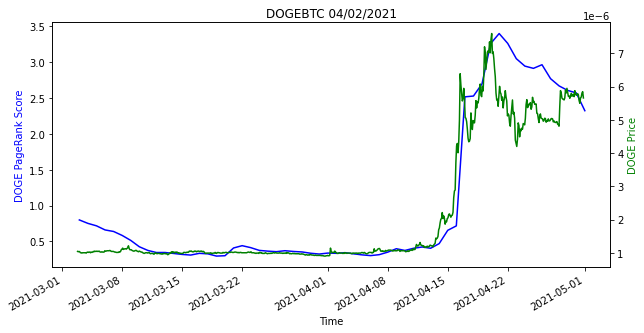

In [19]:
%%time
inc = 32
wind = 30
ticker = "DOGE"
if ticker == "BTC":
    asset = ticker+"USDT"
else:
    asset = ticker+"BTC"

interval = '2h'
newest, oldest = pdrank[ticker].index[inc-wind: inc+wind][-1].to_pydatetime().timestamp() * 1000, pdrank[ticker].index[inc-wind: inc+wind][0].to_pydatetime().timestamp() * 1000, 
klines = client.get_historical_klines(asset, interval, str(oldest), str(newest))
df = get_klines_df(klines)


plt.rcParams['figure.figsize'] = [10, 5]
ts = df["Close"].astype(float) #.pct_change()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()


ax1.plot(pdrank[ticker].index[inc-wind: inc+wind], pdrank[ticker][inc-wind: inc+wind], color='b')

ax2.plot(ts.index, ts, color='g')

ax1.set_xlabel('Time')
ax1.set_ylabel(ticker+" PageRank Score", color='b')
ax2.set_ylabel(ticker +" Price", color='g')
# plt.plot([inc]*2, range(-1,1))
plt.title(asset+" "+from_datetime(pdrank[ticker].index[inc].to_pydatetime())[:-9])
plt.gcf().autofmt_xdate()